In [27]:
!pip install transformers
import torch
import torch.nn as nn
import transformers
from transformers import DistilBertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    DEVICE = torch.device('cuda')
    print("Using cuda.")

SEED = 1234567
MODEL_NAME = 'distilbert-base-uncased'
np.random.seed(SEED)
torch.manual_seed(SEED)
if USE_CUDA:
    torch.cuda.manual_seed(SEED)

COLAB = True

if COLAB:
    from google.colab import drive 
    drive.mount('/content/gdrive')
    PATH = "gdrive/MyDrive/NLP Project/"
else:
  PATH = ""


Using cuda.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
tweets = pd.read_csv(PATH + "data/tweet_eval_clean.csv")

In [30]:
tweets.head()

,Unnamed: 0,text,label,text_clean
0,0,Dark Souls 3 April Launch Date Confirmed With ...,1,dark souls april launch date confirmed with ne...
1,1,"""National hot dog day, national tequila day, t...",2,national hot dog day national tequila day the...
2,2,When girls become bandwagon fans of the Packer...,0,when girls become bandwagon fans of the packer...
3,3,@user I may or may not have searched it up on ...,1,i may or may not have searched it up on google
4,4,Here's your starting TUESDAY MORNING Line up a...,1,here s your starting tuesday morning line up a...


In [31]:
#tweets.sentiment.unique()

In [32]:
#tweets['label'] = np.where(tweets.sentiment == 'negative', 0, np.where(tweets.sentiment == 'neutral', 1, 2))

In [33]:
#tweets.sentiment.value_counts()

In [34]:
#tweets.label.value_counts()

In [35]:
len(tweets)

59874

In [36]:
tweets.dropna(inplace=True, subset=['text_clean'])

In [37]:
len(tweets)

59874

In [38]:
tweets['word_counts'] = tweets.text_clean.str.split().map(len)

<Axes: >

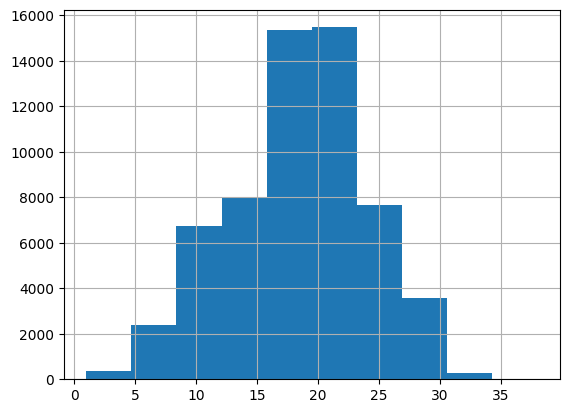

In [39]:
tweets.word_counts.hist()

In [40]:
MAX_LENGTH = 32

In [41]:
train_df , test_df  = train_test_split(tweets, test_size = 0.2, random_state = SEED, shuffle = True)
val_df , test_df  = train_test_split(test_df, test_size = 0.5, random_state = SEED, shuffle = True)

print(train_df.shape , test_df.shape , val_df.shape)

(47899, 5) (5988, 5) (5987, 5)


In [42]:
class Tweets(Dataset):
    def __init__(self, text, target, tokenizer, max_len):
        self.text = text
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self,idx):
        text = self.text[idx]
        encoding = self.tokenizer.encode_plus(
                          text,
                          add_special_tokens=True,
                          max_length=self.max_len,
                          truncation=True,
                          return_token_type_ids=False,
                          pad_to_max_length=True,
                          return_attention_mask=True,
                          return_tensors='pt')
        
        return {'text' : text,
                'input_id': encoding['input_ids'].flatten(),
                'attention_mask':encoding['attention_mask'].flatten(),
                'target': torch.tensor(self.target[idx], dtype = torch.long)
               }
        

In [43]:
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)

training_data = Tweets(text = train_df.text_clean.to_numpy(),
                               target = train_df.label.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LENGTH)

validation_data = Tweets(text = val_df.text_clean.to_numpy(),
                               target = val_df.label.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LENGTH)

test_data = Tweets(text = test_df.text_clean.to_numpy(),
                               target = test_df.label.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LENGTH)

In [44]:
BATCH_SIZE = 64
train_loader = DataLoader(training_data , batch_size = BATCH_SIZE , shuffle = True)
test_loader = DataLoader(test_data , batch_size = BATCH_SIZE , shuffle = False)
val_loader = DataLoader(validation_data , batch_size = BATCH_SIZE , shuffle = False)

In [45]:
# class TweetSentimentClassifier(nn.Module):
#     def __init__(self, num_classes, hid_dim, dropout=0.3):
#         super(TweetSentimentClassifier,self).__init__()
#         self.bert = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_classes)
#         self.dropout = nn.Dropout(p = dropout)
#         self.hidden = nn.Linear(self.bert.config.hidden_size, hid_dim)
#         self.nonlinear = nn.ReLU()
#         self.linear = nn.Linear(hid_dim,num_classes)
        
#     def forward(self,input_ids , attention_mask):
#         temp = self.bert(input_ids,attention_mask) 
#         pooled_output = temp[1]                    
#         out = self.dropout(pooled_output)
#         out = self.nonlinear(self.hidden(out))
#         out = self.dropout(out)  
#         out = self.linear(out)
#         return out

In [46]:
NUM_CLASSES = 3
HIDDEN_DIM = 128

model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_CLASSES)

if USE_CUDA:
  model = model.cuda()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

In [47]:
learning_rate = 2e-5
EPOCHS = 5
total_steps = len(train_loader) * EPOCHS

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = transformers.AdamW(params = model.parameters(),lr = learning_rate, correct_bias= False)

scheduler = transformers.get_linear_schedule_with_warmup(optimizer = optimizer,
                                                        num_warmup_steps = 0,
                                                        num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [48]:
def evaluate(model, data_loader, n_examples):
    model.eval()  
    correct_pred = 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_id']
            attention_masks = batch['attention_mask']
            targets = batch['target']

            if USE_CUDA:
              input_ids = input_ids.cuda()
              attention_masks = attention_masks.cuda()
              targets = targets.cuda()
            output = model(input_ids, attention_masks, labels=targets)
            _,pred_classes = torch.max(output.logits, dim=1)

            correct_pred += torch.sum(pred_classes==targets)
            
    return correct_pred / n_examples

In [49]:
def train_model(model, data_loader, criterion, optimizer, scheduler, n_examples, train_log_interval):
    
    model.train()
    correct_pred = 0

    for i, batch in enumerate(data_loader):
        input_ids = batch['input_id']
        attention_masks = batch['attention_mask']
        targets = batch['target']

        if USE_CUDA:
            input_ids = input_ids.cuda()
            attention_masks = attention_masks.cuda()
            targets = targets.cuda()

        #predictions = model(input_ids , attention_masks)
        outputs = model(input_ids , attention_masks, labels=targets)

        # loss = criterion(predictions, targets)
        _, pred_classes = torch.max(outputs.logits, dim=1)
        loss = outputs.loss
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # hack to avoid gradient explotion
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        correct_pred += torch.sum(pred_classes==targets)

        if (i + 1) % train_log_interval == 0:
            print(f"At iteration {i + 1} the train loss is {loss:.3f}.")
    
    return correct_pred / n_examples
   

In [50]:
TRAIN_LOG_INTERVAL = 300
MODEL_PATH = PATH + "best_sentiment_classifier.pt"

def run_training_loops(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    train_accs = []
    valid_accs = []
    best_valid_acc = 0
    
    for epoch in range(epochs):
        train_acc = train_model(model, train_loader, criterion, optimizer, scheduler, len(train_df), TRAIN_LOG_INTERVAL)
        valid_acc = evaluate(model, val_loader, len(val_df))
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        
        print(f"After epoch {epoch+1} training accuracy is {train_acc}")
        print(f"After epoch {epoch+1} validation accuracy is {valid_acc}")
        
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), MODEL_PATH)
            
            
    return train_accs, valid_accs
        

        
    

In [51]:
training_accuracy, validation_accuracy = run_training_loops(model, train_loader, val_loader, loss_fn, optimizer, scheduler, EPOCHS)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


At iteration 300 the train loss is 0.601.
At iteration 600 the train loss is 0.713.
After epoch 1 training accuracy is 0.6864026188850403
After epoch 1 validation accuracy is 0.7157173752784729
At iteration 300 the train loss is 0.598.
At iteration 600 the train loss is 0.522.
After epoch 2 training accuracy is 0.7766758799552917
After epoch 2 validation accuracy is 0.7125438451766968
At iteration 300 the train loss is 0.472.
At iteration 600 the train loss is 0.439.
After epoch 3 training accuracy is 0.8331906199455261
After epoch 3 validation accuracy is 0.7123767733573914
At iteration 300 the train loss is 0.342.
At iteration 600 the train loss is 0.377.
After epoch 4 training accuracy is 0.8738595247268677
After epoch 4 validation accuracy is 0.7043594121932983
At iteration 300 the train loss is 0.237.
At iteration 600 the train loss is 0.396.
After epoch 5 training accuracy is 0.8977431058883667
After epoch 5 validation accuracy is 0.7090362310409546


In [69]:
def get_predictions(model, data_loader):
    model = model.eval()

    tweets = []
    predictions = []
    real_values = []

    with torch.no_grad():
        for batch in data_loader:

            texts = batch["text"]
            input_ids = batch["input_id"]
            attention_masks = batch["attention_mask"]
            targets = batch["target"]

            if USE_CUDA:
              input_ids = input_ids.cuda()
              attention_masks = attention_masks.cuda()
              targets = targets.cuda()

            outputs = model(input_ids, attention_masks, labels=targets)

            _,preds = torch.max(outputs.logits, dim=1)

            

            tweets.extend(texts)
            predictions.extend(preds)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cuda()
    real_values = torch.stack(real_values).cuda()
    return tweets, predictions, real_values

In [53]:
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [70]:
y_tweets, y_pred, y_test = get_predictions(model,test_loader)

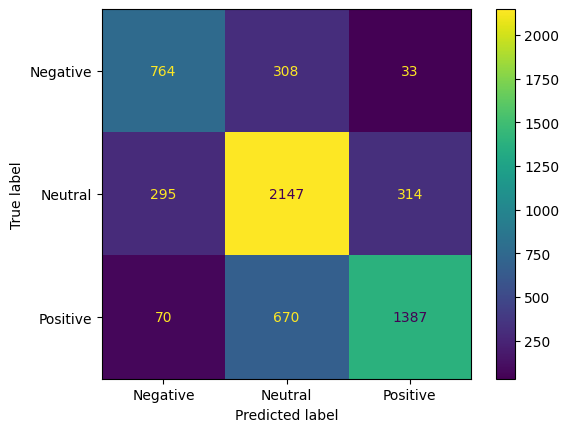

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test = y_test.cpu()
y_pred = y_pred.cpu()

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', "Positive"])
disp.plot()

In [72]:
print(f"Test Accuracy: {(y_test == y_pred).sum()/len(y_test)}")

Test Accuracy: 0.7177688479423523


In [73]:
accuarcy_df = pd.DataFrame({"training_accuarcy": [t.detach().cpu() for t in training_accuracy], })

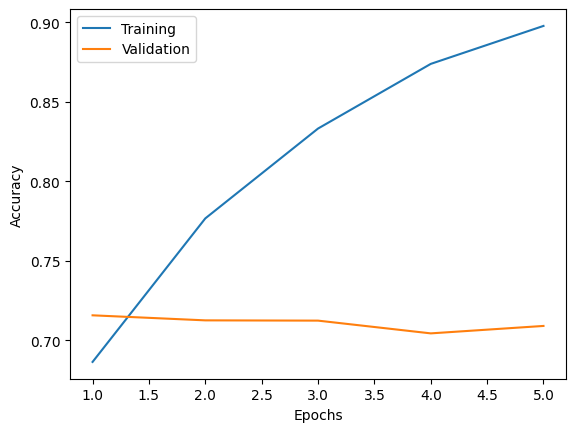

In [75]:
plt.plot(range(1, len(training_accuracy) + 1),[t.detach().cpu() for t in training_accuracy], label="Training" )
plt.plot(range(1, len(validation_accuracy) + 1),[t.detach().cpu() for t in validation_accuracy], label="Validation" )
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig(PATH + "sentiment_classifier_accuracy2.png")

In [76]:
from sklearn.metrics import precision_recall_fscore_support

In [77]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.67670505, 0.68704   , 0.79988466]),
 array([0.69140271, 0.77902758, 0.65209215]),
 array([0.68397493, 0.73014793, 0.71846672]),
 array([1105, 2756, 2127]))